## Solutions Proposed to Olist

A late delivery occurs when an order's actual shipping date exceeds its estimated delivery date. This creates a gap between customer expectations and our operational capabilities. So we propose two solutions:

1. *Develop more realistic delivery timeframes based on historical data, ensuring we can consistently meet or exceed customer expectations*

2. *If the goal is to deliver fast, can we estimate the capacity of orders we're able to timely deliver? This could have an impact on number of orders*


**This analysis will explore both solutions, providing actionable metrics and recommendations for implementation**

In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore

import matplotlib.pyplot as plt # type: ignore

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error 
from sklearn.ensemble import GradientBoostingRegressor

import joblib

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
# functions
def assign_time_of_day(hour):
    if 5 <= hour < 12:  # Morning: 5 AM to 11:59 AM
        return 0
    elif 12 <= hour < 17:  # Afternoon: 12 PM to 4:59 PM
        return 1
    elif 17 <= hour < 21:  # Evening: 5 PM to 8:59 PM
        return 2
    else:  # Night: 9 PM to 4:59 AM
        return 3
    
# plotting 
def plot_data(df, col_plot_1, col_plot_2, label_plot_1, label_plot_2, title):
    fig, ax1 = plt.subplots(figsize=(20, 8))

    ax1.plot(df[col_plot_1], color='blue')
    ax1.set_ylabel(label_plot_1, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(df[col_plot_2], color='orange', alpha=0.5)
    ax2.set_ylabel(label_plot_2, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    fig.suptitle(title, fontsize=16)
    ax1.set_xlabel('Date')
    plt.show()

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_pred, y_true))

In [20]:
df = pd.read_csv("../data/processed/data.csv", parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date'])

df['purchase_date_hour'] = df['order_purchase_timestamp'].dt.floor('H')
df['gap_in_minutes_approved_and_ordered'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600
df['order_purchase_date'] = pd.to_datetime(df['order_purchase_timestamp'].dt.date)
df['year'] = df['order_purchase_timestamp'].dt.year

In [24]:
temp_df = df[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date',  'late_delivery_in_days', 'is_delivery_late', 
              'month', 'year', 'purchase_date_hour', 'gap_in_minutes_approved_and_ordered', 'order_purchase_date']]

### Percentage of late deliveries

In [25]:
temp_df['is_delivery_late'].value_counts(normalize=True)

is_delivery_late
0    0.935842
1    0.064158
Name: proportion, dtype: float64

### Percentage of late deliveries by month

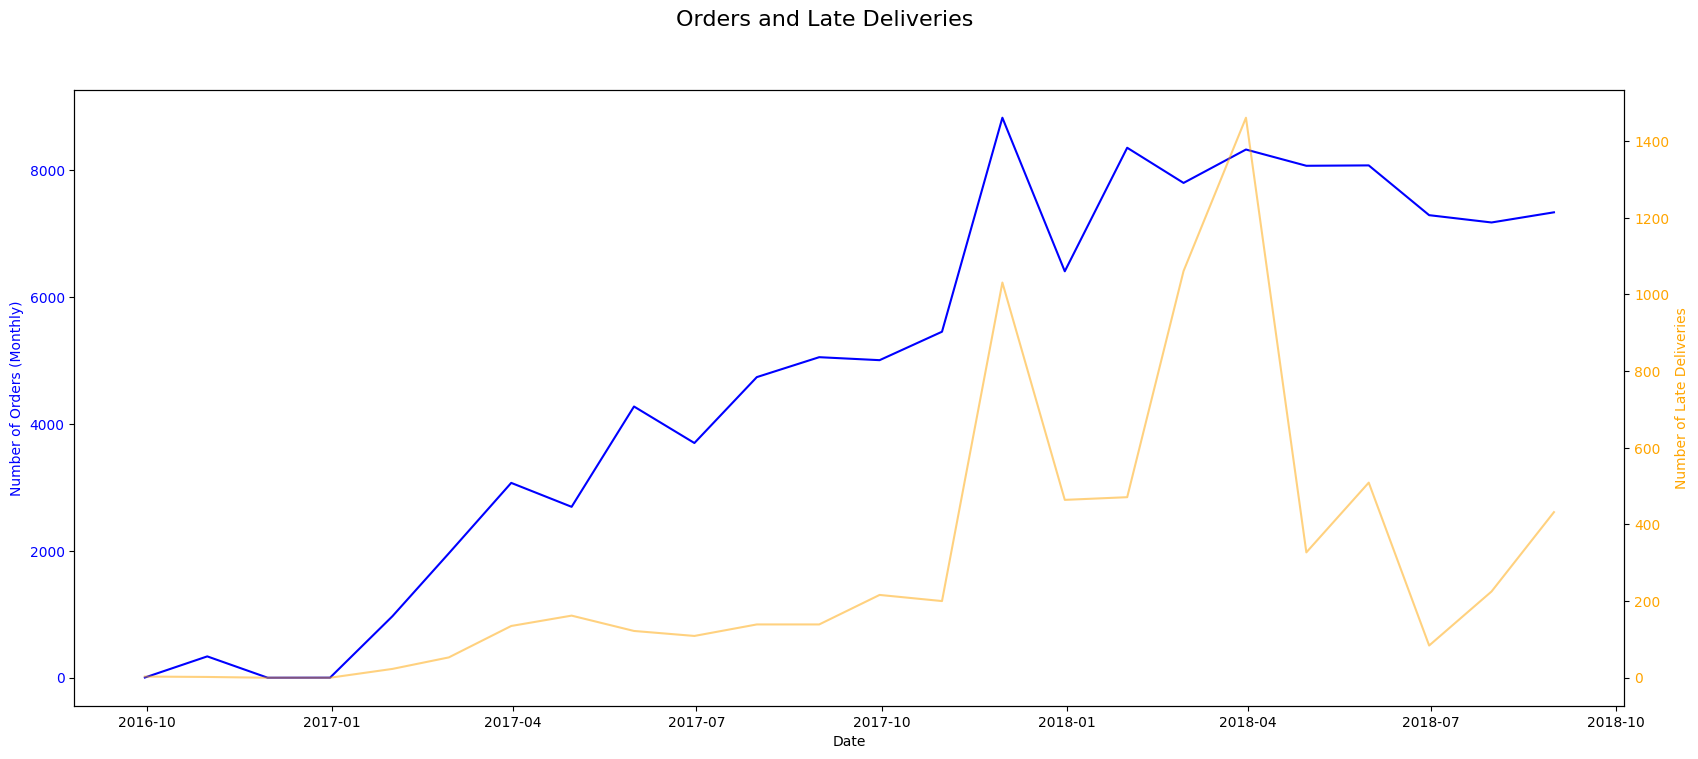

In [32]:
monthly_data = temp_df.groupby(pd.Grouper(key='order_purchase_date', freq='M')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late', 'sum'))

plot_data(df=monthly_data,
          col_plot_1='count_orders', 
          col_plot_2='num_late_deliveries', 
          label_plot_1='Number of Orders (Monthly)', 
          label_plot_2='Number of Late Deliveries', 
          title='Orders and Late Deliveries')

### Percentage of late deliveries by week

Group by week and counting the total number of orders and number of late deliveries

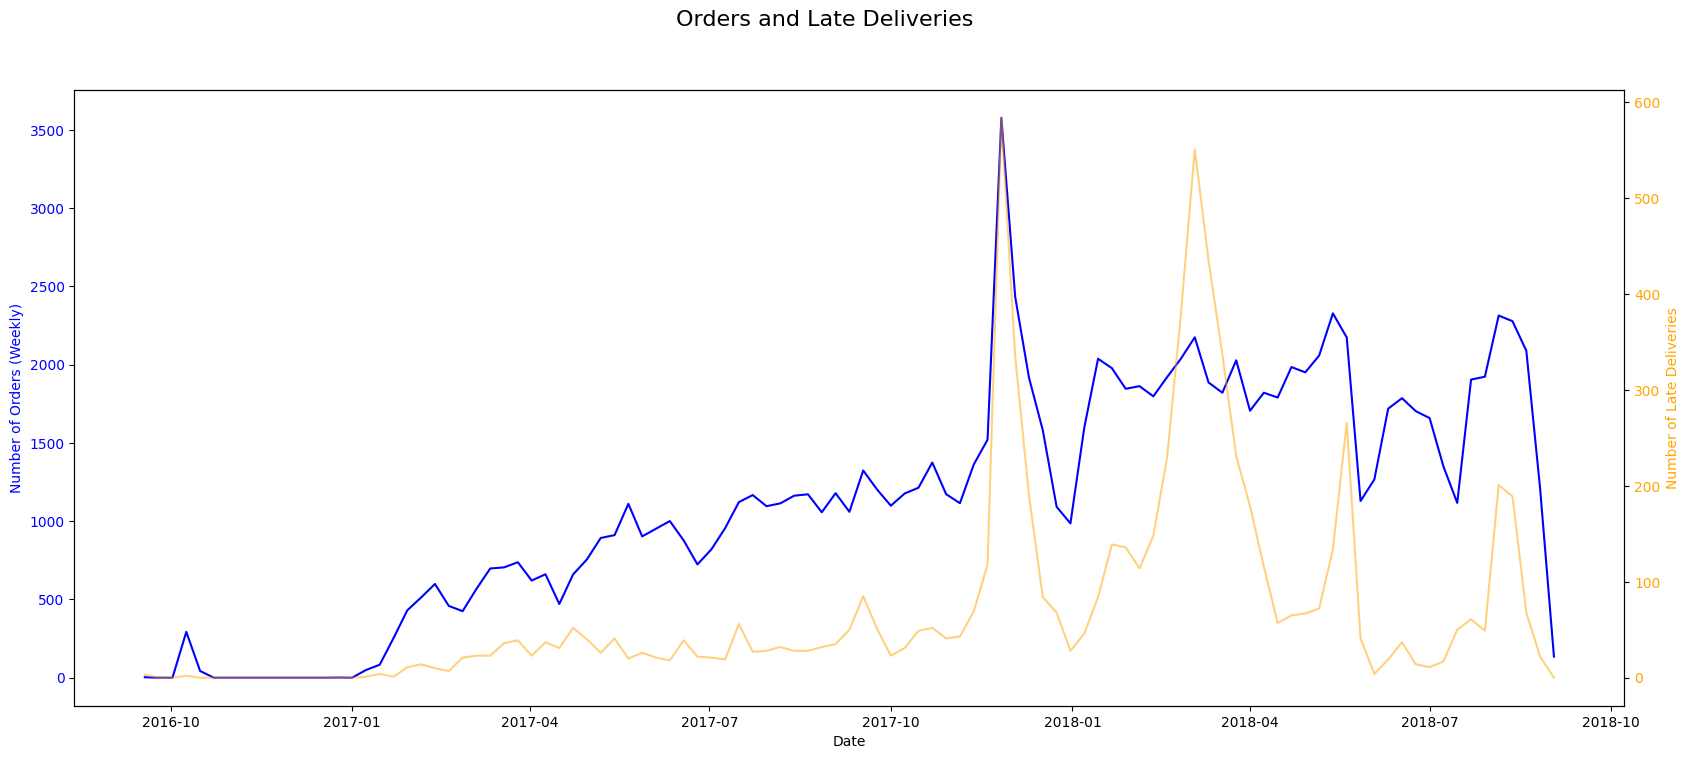

In [34]:
weekly_data = temp_df.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late', 'sum'))

plot_data(df=weekly_data,
          col_plot_1='count_orders', 
          col_plot_2='num_late_deliveries', 
          label_plot_1='Number of Orders (Weekly)', 
          label_plot_2='Number of Late Deliveries', 
          title='Orders and Late Deliveries')

Percentage of late deliveries per week

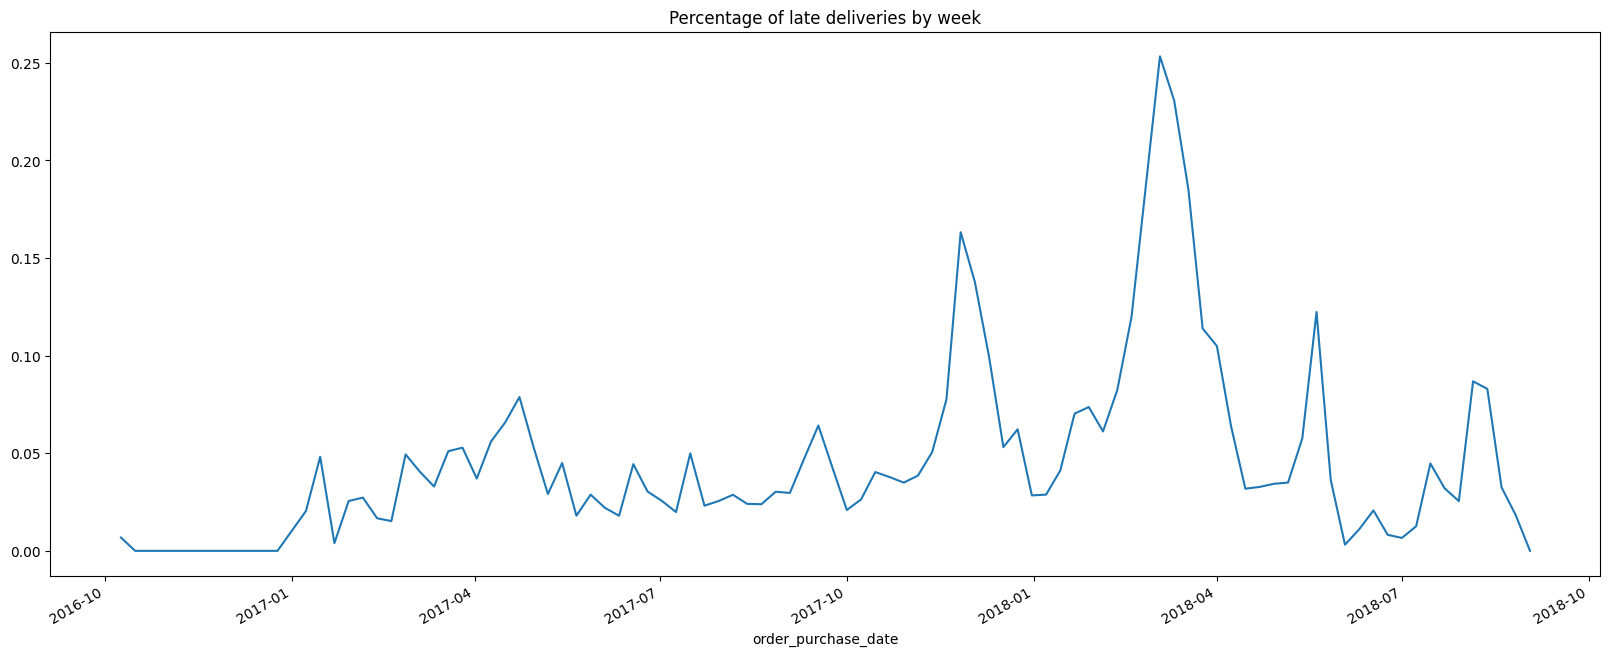

In [35]:
weekly_data['perc_late_deliveries'] = weekly_data['num_late_deliveries'] / weekly_data['count_orders']
plt.figure(figsize=(20, 8))
weekly_data[(weekly_data['perc_late_deliveries'].notna()) & (weekly_data['perc_late_deliveries'] != 1)]['perc_late_deliveries'].plot()
plt.title("Percentage of late deliveries by week")
plt.show()

---

there're two timestamps:
- **order_purchase_date**: this is when the customer purchases from Olist
- **order_approved_at**: this is when the order gets approved

We wanted to explore if the time it took to approve an order increases as the volume of orders increases

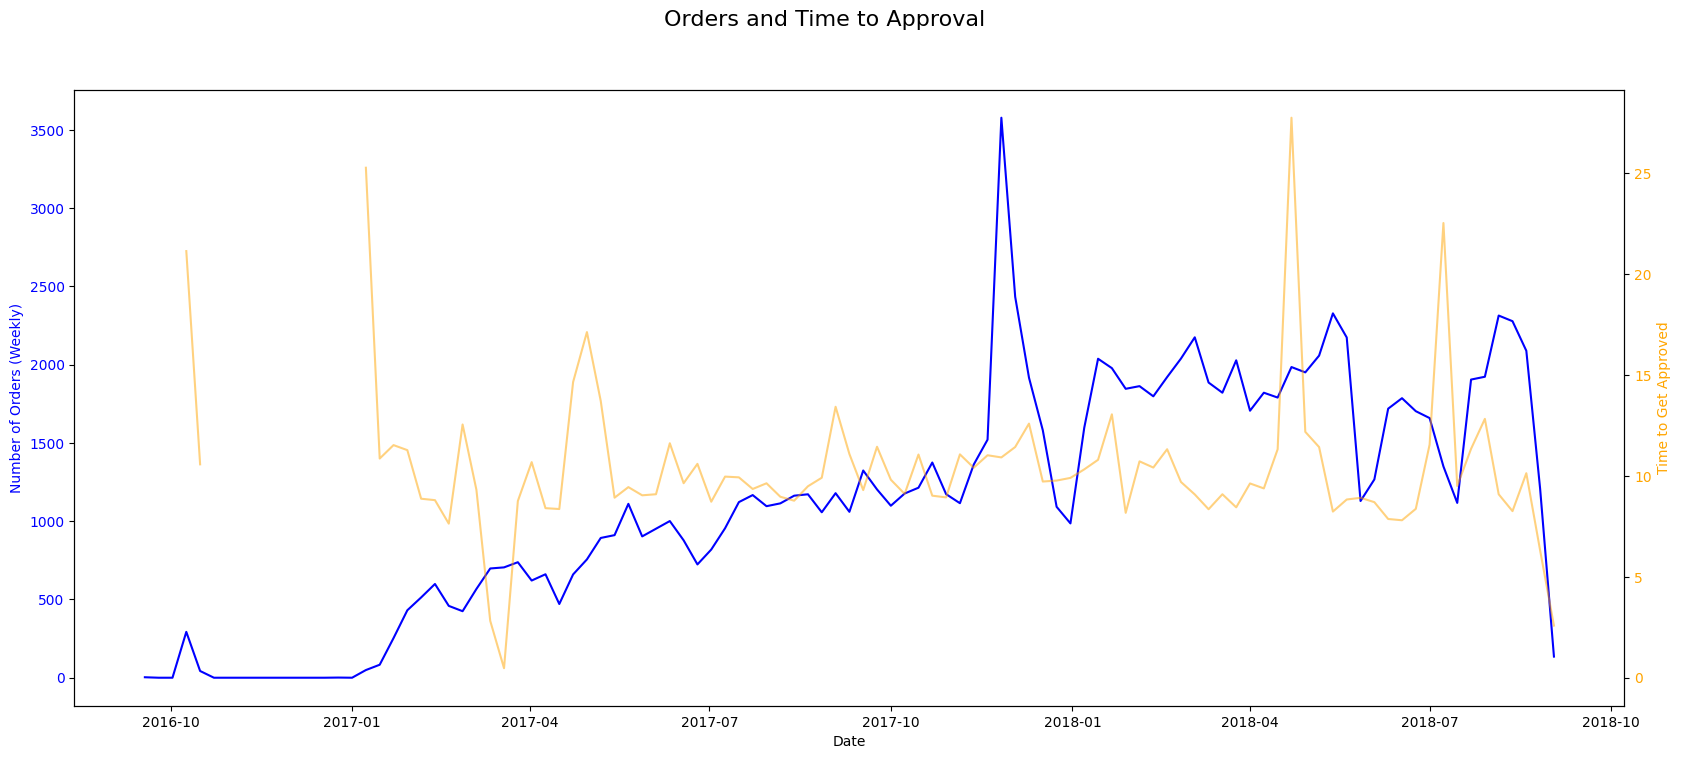

In [36]:
# Group by weekly periods and aggregate data
weekly_data = temp_df.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('purchase_date_hour', 'count'),
    gap_approved_ordered = ('gap_in_minutes_approved_and_ordered', 'mean')
)

plot_data(df=weekly_data,
          col_plot_1='count_orders', 
          col_plot_2='gap_approved_ordered', 
          label_plot_1='Number of Orders (Weekly)', 
          label_plot_2='Time to Get Approved', 
          title='Orders and Time to Approval')

---

## Expectation Management

1. *Develop more realistic delivery timeframes based on historical data, ensuring we can consistently meet or exceed customer expectations*

In the dataset provided by Olist, we're given the *ordered_delivered_customer_date* and the *order_estimated_delivery_date*, so we're given the *actual* and the *estimated* values which allows to estimate the **late deliveries rate**. We could use that as benchmark to try and create a model that's better than the one they currently have.


**Metrics we want to optimize for**: Late Delivery Rate

In [41]:
def late_delivery_rate(y_true, y_pred):
    # This is the metric we want to optimize for
    late_deliveries = np.sum(y_pred < y_true)
    return late_deliveries / len(y_true)

def coverage_rate(y_true, lower_bound, upper_bound):
    # Check if actual values fall within the interval
    within_interval = (y_true >= lower_bound) & (y_true <= upper_bound)
    return np.mean(within_interval)

model features

In [42]:
df['dow'] = df['order_purchase_timestamp'].dt.day_of_week
df['hour'] = df['order_purchase_timestamp'].dt.hour
df['time_of_day'] = df['order_purchase_timestamp'].dt.hour.map(assign_time_of_day)

df['days_to_actual_delivery'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
df['days_to_actual_delivery_log'] = np.log(df['days_to_actual_delivery']+1)
df['days_to_estimated_delivery'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days

df['is_december'] = 0
df.loc[df['month'].isin([11,12]), 'is_december'] = 1

df['is_summer'] = 0
df.loc[df['month'].isin([5,6,7,8]), 'is_summer'] = 1

In [43]:
olist_model_late_delivery_rate = late_delivery_rate(df['days_to_actual_delivery'], df['days_to_estimated_delivery'])
print(f"Late Delivery Rate for Olist current estimated delivery model: {olist_model_late_delivery_rate:.4f}")

Late Delivery Rate for Olist current estimated delivery model: 0.0720



**Problem:** Olist's current model has a late delivery rate of **7.2%**, setting our benchmark.

**Solution:** Build a predictive model that outperforms this benchmark using the available features.

If we want to build a robus predictive model that minimizes late delivery rate, a good feature would be late_delivery_rate in the weeks prior to the week the order is taking place. We can see from the visuals above that there is some seasonality around the holidays, so this would help the model capture some of those patterns

In [44]:
df_clean = df.drop_duplicates(subset=['order_id'])
df_clean.sort_values(by='order_purchase_timestamp', inplace=True)

df_clean['purchase_date_hour'] = df_clean['order_purchase_timestamp'].dt.floor('H')
df_clean['week_start'] = (df['order_purchase_timestamp'] - pd.to_timedelta(df['order_purchase_timestamp'].dt.weekday + 1, unit='D')).dt.date
df_clean['week_start'] = pd.to_datetime(df_clean['week_start'])

weekly_data = df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late', 'sum')).reset_index()

weekly_data['perc_late_deliveries'] = weekly_data['num_late_deliveries'] / weekly_data['count_orders']
weekly_data['perc_late_deliveries'].fillna(0, inplace=True)

df_clean = pd.merge(df_clean, weekly_data, how='left', left_on='week_start', right_on='order_purchase_date', suffixes=('', '_duplicate'))

# Lagging the weekly percentage late deliveries variable to know the late delivery rate from the previous weeks
for i in range(1,3):
    df_clean[f'perc_late_deliveries_lag_{i}'] = df_clean['perc_late_deliveries'].shift(i)
    df_clean.dropna(subset=[f'perc_late_deliveries_lag_{i}'], inplace=True)

In [45]:
df_clean[['days_to_actual_delivery', 'perc_late_deliveries', 'perc_late_deliveries_lag_1', 'perc_late_deliveries_lag_2']].corr()

,days_to_actual_delivery,perc_late_deliveries,perc_late_deliveries_lag_1,perc_late_deliveries_lag_2
days_to_actual_delivery,1.000000,0.188378,0.188358,0.188346
perc_late_deliveries,0.188378,1.000000,0.999881,0.999763
perc_late_deliveries_lag_1,0.188358,0.999881,1.000000,0.999881
perc_late_deliveries_lag_2,0.188346,0.999763,0.999881,1.000000


## Features

In [46]:
features = [
'is_summer',
'freight_value',
'distance_km',
'month',
'dow',
'is_december',
'perc_late_deliveries_lag_1']

target = 'days_to_actual_delivery_log'
X, y = df_clean[features], df_clean[target]

## Ensemble Model

**Gradient Boosting**

We're using *days to actual delivery* as our dependent variable. This variable is constructed as the days that pass from the order purchase date to the actual delivery date. So what we're predicting is the number of days that will pass from the day a customer makes an order. 

This will then be used to construct our "is_late_delivery" variable, using this logic:

A delivery is late if:

- **Days to Actual Delivery > Days to Estimated Delivery (this is the model's prediction)**

Otherwise, the delivery is on time:

- **Days to Actual Delivery < Days to Estimated Delivery**

This introduces a lot of additional things that we must have into account. 

1. When we create a predictive model, our model could be wrong in two directions:


    - We overestimate the delivery days
    - We underestimate the delivery days

The issue arises when we underestimate the delivery days, meaning:

- Days to Actual Delivery > Days to Estimated Delivery

if we overestimate it, this means our delivery arrived earlier than expected. This is most of the time a preferred thing.

So in this case, only one direction matters, and therefore we decided to estimate an interval of days to estimated delivery, using a 95th confidence interval.


In [55]:
df_clean.set_index("order_purchase_date", inplace=True)

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'price', 'freight_value', 'payment_value', 'Rating',
       'review_creation_date', 'review_answer_timestamp',
       'product_category_name', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'geolocation_lat_x', 'geolocation_lng_x',
       'geolocation_lat_y', 'geolocation_lng_y', 'month',
       'product_category_name_encoded', 'seller_id_encoded', 'rainfall',
       'product_weight_kg', 'product_size', 'no_photos', 'product_price',
       'late_delivery_in_days', 'is_delivery_late', 'distance_km',
       'customer_experience', 'seller_a

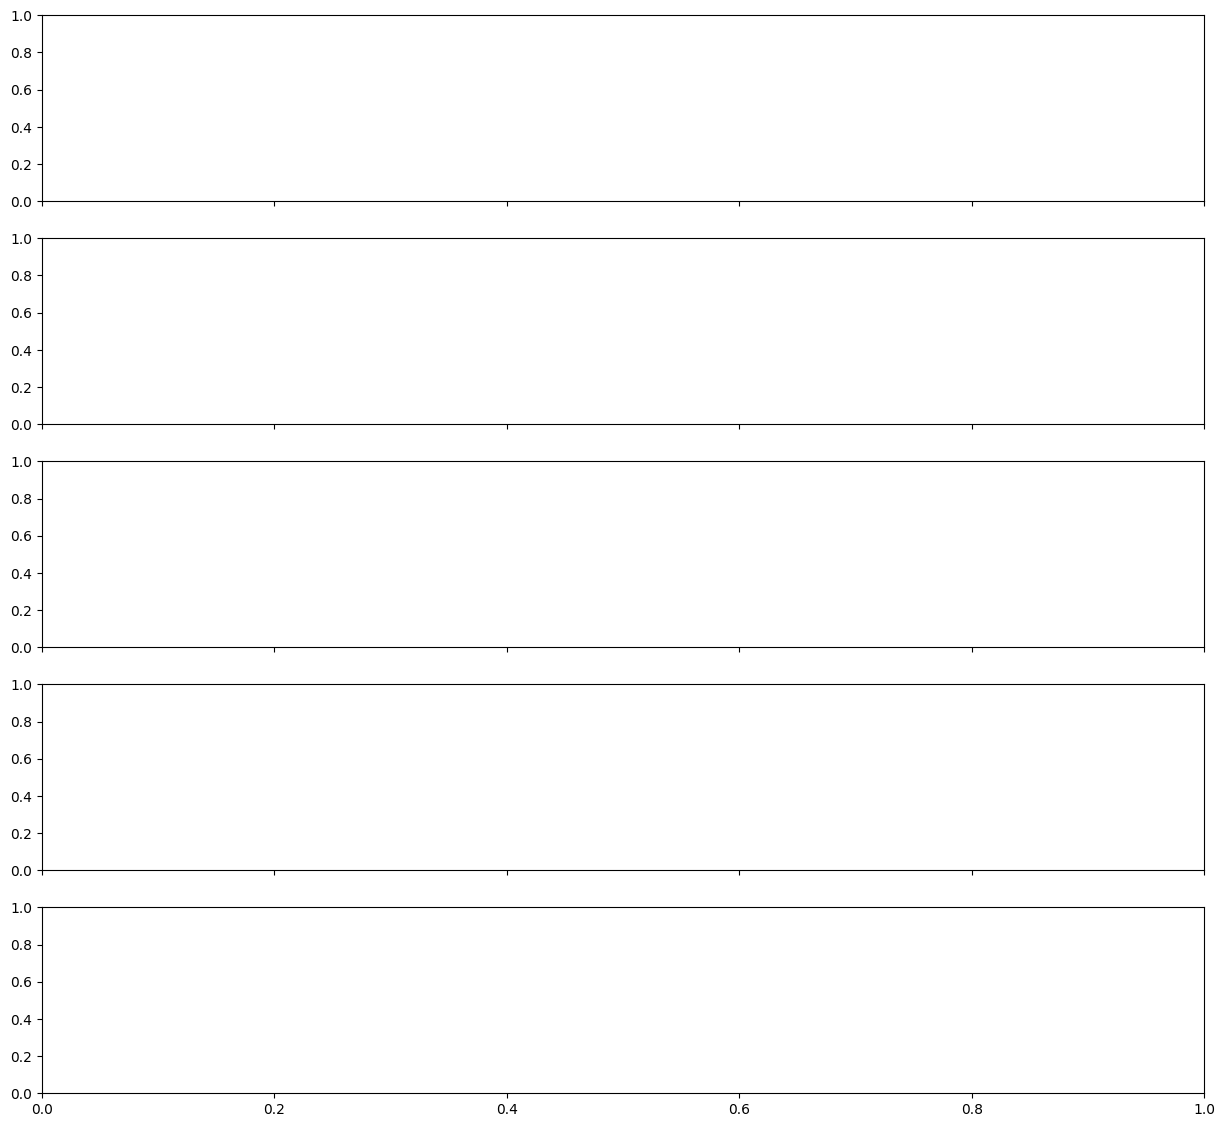

In [59]:
from sklearn.model_selection import TimeSeriesSplit


tss = TimeSeriesSplit(n_splits=5, test_size=30)
fig, axs = plt.subplots(5,1,figsize=(15,14), sharex=True)

for train_idx, val_idx in tss.split(df_clean):

    train_set = df_clean.iloc[train_idx]
    validation_set = df_clean.iloc[val_idx]

    X_train, y_train = train_set[features], train_set[target]
    X_val, y_val = validation_set[features], validation_set[target]

    # Lower bound model (2.5th percentile)
    lower_model = GradientBoostingRegressor(loss="quantile", alpha=0.025, random_state=42)
    lower_model.fit(X_train, y_train)

    # Upper bound model (97.5th percentile)
    upper_model = GradientBoostingRegressor(loss="quantile", alpha=0.975, random_state=42)
    lower_model.fit(X_train, y_train)

    # Predictions
    lower_bound = lower_model.predict(X_val)
    upper_bound = upper_model.predict(X_val)

    ldr_outside_ci = late_delivery_rate(y_true=y_val, y_pred=upper_bound)

In [60]:
df_clean

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,price,freight_value,payment_value,Rating,review_creation_date,review_answer_timestamp,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_x,geolocation_lng_x,geolocation_lat_y,geolocation_lng_y,month,product_category_name_encoded,seller_id_encoded,rainfall,product_weight_kg,product_size,no_photos,product_price,late_delivery_in_days,is_delivery_late,distance_km,customer_experience,seller_avg_rating,purchase_date_hour,gap_in_minutes_approved_and_ordered,year,dow,hour,time_of_day,days_to_actual_delivery,days_to_actual_delivery_log,days_to_estimated_delivery,is_december,is_summer,week_start,order_purchase_date_duplicate,count_orders,num_late_deliveries,perc_late_deliveries,perc_late_deliveries_lag_1,perc_late_deliveries_lag_2
order_purchase_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-10-03,a41c8759fbe7aab36ea07e038b2d4465,6f989332712d3222b6571b1cf5b835ce,delivered,2016-10-03 21:13:36,2016-10-05 03:11:49,2016-11-03 10:58:07,2016-11-29,1.0,b72b39418216e944bb34e35f4d3ea8c7,45d33f715e24d15a6ccf5c17b3a23e3c,36.49,17.24,53.73,3.0,2016-11-04 00:00:00,2016-11-04 23:45:17,esporte_lazer,1.0,767.0,26.0,8.0,20.0,61db744d2f835035a5625b59350c6b63,90040,porto alegre,RS,18015.0,sorocaba,SP,-30.041161,-51.213661,-23.502755,-47.430451,10,32,815,South,0.767,4160.0,1.0,36.49,-26,0,818.146504,3.0,3.000000,2016-10-03 21:00:00,29.970278,2016,0,21,3,30,3.433987,56,0,0,2016-10-02,2016-10-02,0.0,0.0,0.000000,0.000000,0.000000
2016-10-03,d207cc272675637bfed0062edffd0818,b8cf418e97ae795672d326288dfab7a7,delivered,2016-10-03 22:06:03,2016-10-04 10:28:07,2016-10-31 11:07:42,2016-11-23,1.0,107177bf61755f05c604fe57e02467d6,cca3071e3e9bb7d12640c9fbe2301306,119.90,13.56,133.46,1.0,2016-11-01 00:00:00,2016-11-02 16:52:00,moveis_decoracao,1.0,2050.0,40.0,11.0,34.0,8d3a54507421dbd2ce0a1d58046826e0,13185,hortolandia,SP,14940.0,ibitinga,SP,-22.892792,-47.173849,-21.757321,-48.829744,10,54,2387,Southeast,2.050,14960.0,1.0,119.90,-23,0,212.014865,1.0,4.555556,2016-10-03 22:00:00,12.367778,2016,0,22,3,27,3.332205,50,0,0,2016-10-02,2016-10-02,0.0,0.0,0.000000,0.000000,0.000000
2016-10-03,cd3b8574c82b42fc8129f6d502690c3e,7812fcebfc5e8065d31e1bb5f0017dae,delivered,2016-10-03 22:31:31,2016-10-04 10:19:23,2016-10-14 16:08:00,2016-11-23,1.0,e2a1d45a73dc7f5a7f9236b043431b89,b499c00f28f4b7069ff6550af8c1348a,29.99,10.96,40.95,5.0,2016-10-19 00:00:00,2016-10-22 00:23:57,fashion_calcados,2.0,9000.0,16.0,5.0,33.0,87776adb449c551e74c13fc34f036105,12030,taubate,SP,13481.0,limeira,SP,-23.032142,-45.570461,-22.600004,-47.407129,10,34,2082,Southeast,9.000,2640.0,2.0,29.99,-40,0,194.282267,5.0,5.000000,2016-10-03 22:00:00,11.797778,2016,0,22,3,10,2.397895,50,0,0,2016-10-02,2016-10-02,0.0,0.0,0.000000,0.000000,0.000000
2016-10-03,ae8a60e4b03c5a4ba9ca0672c164b181,e6f959bf384d1d53b6d68826699bba12,delivered,2016-10-03 22:44:10,2016-10-04 10:28:25,2016-11-03 14:04:50,2016-12-01,1.0,a5c3ddb1a400f50d1cf7138727aec136,817f85dbb65aa3e70831d90fe75cdf89,128.90,25.67,154.57,5.0,2016-11-04 00:00:00,2017-01-30 17:17:50,brinquedos,1.0,7811.0,45.0,28.0,46.0,7390ed59fa1febbfda31a80b4318c8cb,76700,mozarlandia,GO,18530.0,tiete,SP,-14.751274,-50.568165,-23.101621,-47.711819,10,12,1532,Central-West,7.811,57960.0,1.0,128.90,-28,0,975.801286,5.0,4.428571,2016-10-03 22:00:00,11.737500,2016,0,22,3,30,3.433987,58,0,0,2016-10-02,2016-10-02,0.0,0.0,0.000000,0.000000,0.000000
2016-10-03,ef1b29b591d31d57c0d7337460dd83c9,dc607dc98d6a11d5d04d9f2a70aa6c34,delivered,2016-10-03 22:51:30,2016-10-04 10:28:19,2016-11-01 15:14:45,2016-11-25,1.0,bfce5e847034e1fbbc1ed0bff6a372c7,cca3071e3e9bb7d12640c9fbe2301306,74.90,17.37,92.27,1.0,2016-1

In [52]:
# Lower bound model (2.5th percentile)
lower_model = GradientBoostingRegressor(loss="quantile", alpha=0.025, random_state=42)
lower_model.fit(X, y)

# Upper bound model (97.5th percentile)
upper_model = GradientBoostingRegressor(loss="quantile", alpha=0.975, random_state=42)
upper_model.fit(X, y)

# Predictions
lower_bound = lower_model.predict(X)
upper_bound = upper_model.predict(X)

In [54]:
ldr_outside_ci = late_delivery_rate(y_true=y, y_pred=upper_bound)
print(f"Late Delivery Rate Outside CI: {ldr_outside_ci:.4f}")

Late Delivery Rate Outside CI: 0.0250


In [139]:
# Saving models
joblib.dump(lower_model, '../results/models/gb_model_lb.joblib')
joblib.dump(upper_model, '../results/models/gb_model_ub.joblib')

['../results/models/gb_model_ub.joblib']

this model improves the 7.4% late delivery rate that we observed in Olist's current model

In [55]:
df_clean['days_to_estimated_delivery_model_lb'] = np.exp(lower_bound) - 1
df_clean['days_to_estimated_delivery_model_ub'] = np.exp(upper_bound) - 1

# Calculating late deliveries using our model
df_clean['is_delivery_late_gb'] = np.where(df_clean['days_to_actual_delivery'] > df_clean['days_to_estimated_delivery_model_ub'], 1, 0)

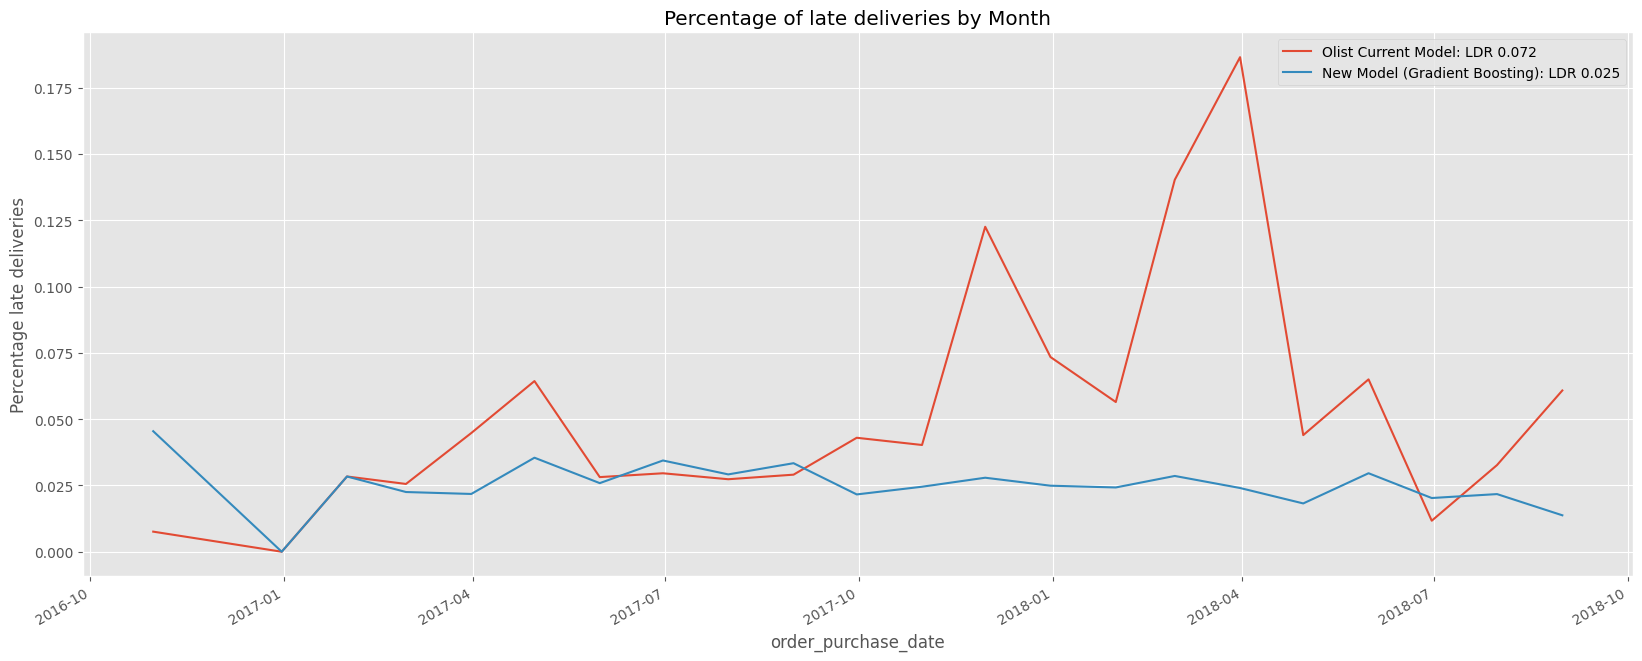

In [49]:
weekly_data_model_current = df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='M')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late', 'sum'))

weekly_data_model_gb= df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='M')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late_gb', 'sum'))

weekly_data_model_current['perc_late_deliveries'] = weekly_data_model_current['num_late_deliveries'] / weekly_data_model_current['count_orders']
weekly_data_model_gb['perc_late_deliveries'] = weekly_data_model_gb['num_late_deliveries'] / weekly_data_model_gb['count_orders']

olist_ldr = late_delivery_rate(df['days_to_actual_delivery'], df['days_to_estimated_delivery']).round(3)
new_model_ldr = late_delivery_rate(y_true=y, y_pred=upper_bound).round(3)

plt.figure(figsize=(20, 8))
weekly_data_model_current[(weekly_data_model_current['perc_late_deliveries'].notna()) & (weekly_data_model_current['perc_late_deliveries'] != 1)]['perc_late_deliveries'].plot(label=f'Olist Current Model: LDR {olist_ldr}')
weekly_data_model_gb[(weekly_data_model_gb['perc_late_deliveries'].notna()) & (weekly_data_model_gb['perc_late_deliveries'] != 1)]['perc_late_deliveries'].plot(label=f'New Model (Gradient Boosting): LDR {new_model_ldr}')
plt.title("Percentage of late deliveries by Month")
plt.ylabel("Percentage late deliveries")
plt.legend()
plt.show()

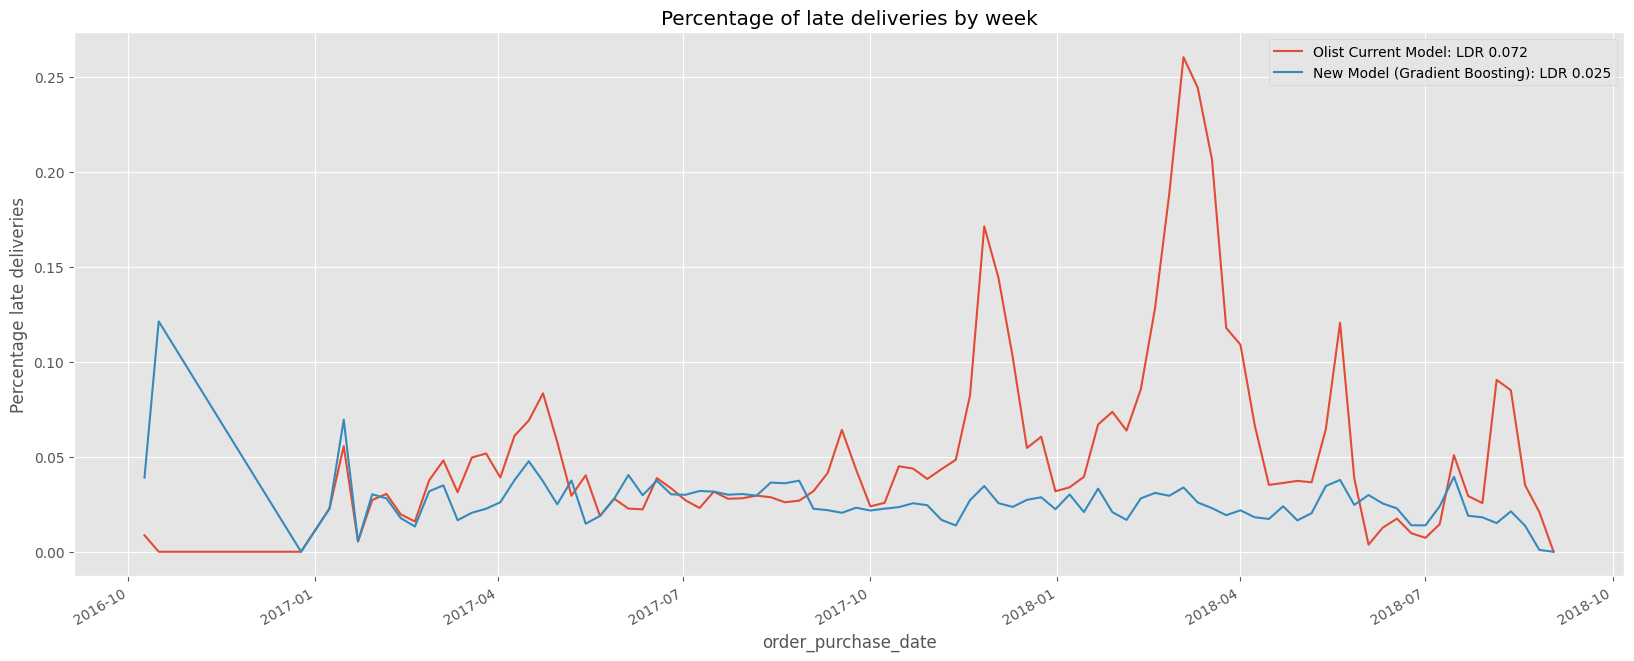

In [56]:
weekly_data_model_current = df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late', 'sum'))

weekly_data_model_gb= df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late_gb', 'sum'))

weekly_data_model_current['perc_late_deliveries'] = weekly_data_model_current['num_late_deliveries'] / weekly_data_model_current['count_orders']
weekly_data_model_gb['perc_late_deliveries'] = weekly_data_model_gb['num_late_deliveries'] / weekly_data_model_gb['count_orders']

olist_ldr = late_delivery_rate(df['days_to_actual_delivery'], df['days_to_estimated_delivery']).round(3)
new_model_ldr = late_delivery_rate(y_true=y, y_pred=upper_bound).round(3)

plt.figure(figsize=(20, 8))
weekly_data_model_current[(weekly_data_model_current['perc_late_deliveries'].notna()) & (weekly_data_model_current['perc_late_deliveries'] != 1)]['perc_late_deliveries'].plot(label=f'Olist Current Model: LDR {olist_ldr}')
weekly_data_model_gb[(weekly_data_model_gb['perc_late_deliveries'].notna()) & (weekly_data_model_gb['perc_late_deliveries'] != 1)]['perc_late_deliveries'].plot(label=f'New Model (Gradient Boosting): LDR {new_model_ldr}')
plt.title("Percentage of late deliveries by week")
plt.ylabel("Percentage late deliveries")
plt.legend()
plt.show()

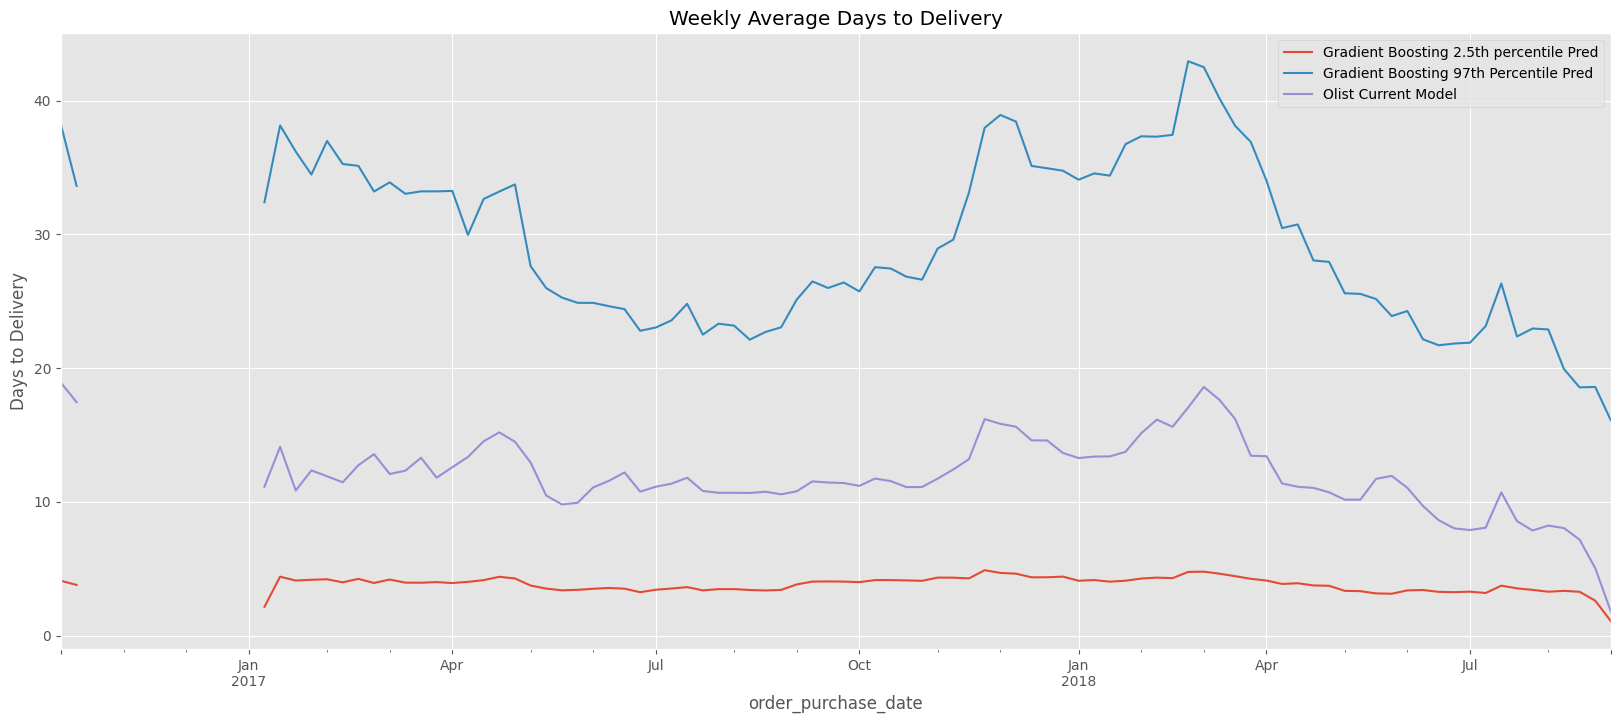

In [57]:
weekly_data_model_lb = df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    days_to_estimated_delivery_lb = ('days_to_estimated_delivery_model_lb', 'mean'))

weekly_data_model_ub = df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    days_to_estimated_delivery_ub = ('days_to_estimated_delivery_model_ub', 'mean'))

weekly_data_model_actual= df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    days_to_actual_delivery = ('days_to_actual_delivery', 'mean'))


plt.figure(figsize=(20, 8))
weekly_data_model_lb['days_to_estimated_delivery_lb'].plot(label='Gradient Boosting 2.5th percentile Pred')
weekly_data_model_ub['days_to_estimated_delivery_ub'].plot(label='Gradient Boosting 97th Percentile Pred')
weekly_data_model_actual['days_to_actual_delivery'].plot(label='Olist Current Model')
plt.legend()
plt.ylabel("Days to Delivery")
plt.title("Weekly Average Days to Delivery")
plt.show()

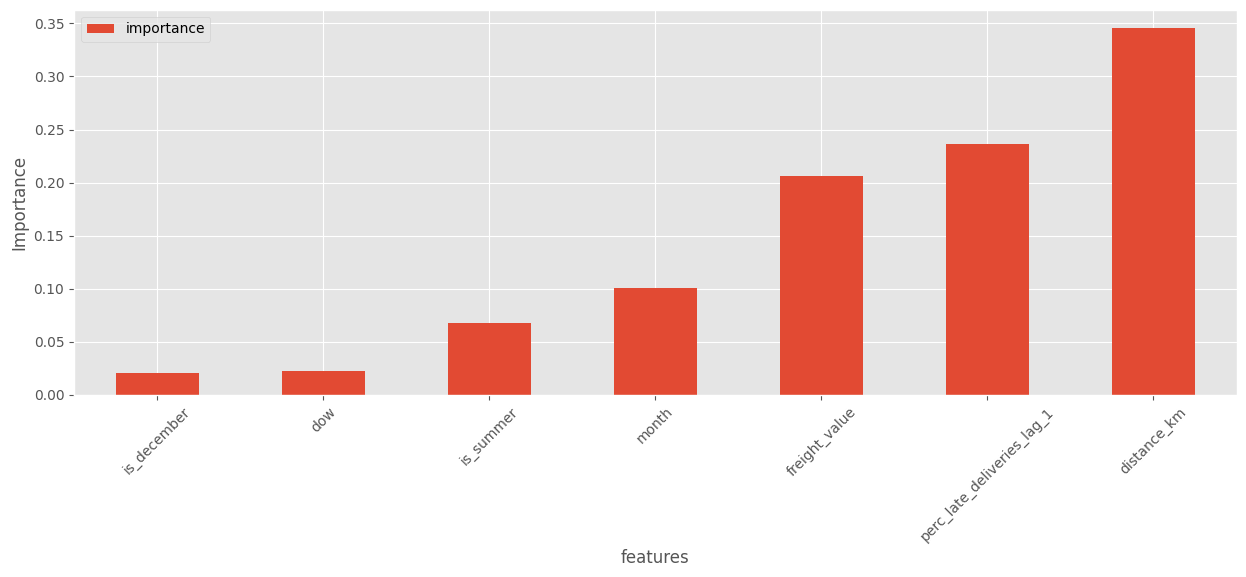

In [58]:
features_df = pd.DataFrame({'features':upper_model.feature_names_in_, 'importance': upper_model.feature_importances_})
features_df.sort_values(by='importance').set_index("features").plot(kind='bar', figsize=(15,5))
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()

# Business Recommendations: *Pursue the Small Wins*

Implementing changes in the supply chain may be costly, and it may require significant efforts to carry it out efficiently. On the other hand, limiting the capacity of order Olist receives in order to minimize late deliveries may result in fewer orders and a negative impact on revenue and profit.

As a result, we would love to propose to pursue the small win. Improve the current estimated delivery model and better manage customers expectations. This does not affect order capacities and the only cost may be the hours of work the engineers will have to put in order to deploy this model efficiently.

We have built a model that does not rely in predicting an exact delivery date, but an interval of when this will be delivered. Our model has a late delivery rate of less than 3%, improving Olist's current model by ~4%. This results in fewer late deliveries and we hope it affects customer satisfaction positively.

---

# Measuring Revenue Impact

Revenue Loss = (Total Customers * Late Delivery Rate) x Customer Lifetime Value x Impact Per Late Delivery

In [5]:
df.drop_duplicates(subset='order_id', inplace=True)

**Estimating customer LTV**

In [6]:
average_order_value = df['payment_value'].mean()
average_repeat_purchase = sum(df['customer_unique_id'].value_counts() > 1) / len(df['customer_unique_id'].unique()) * 100
customer_ltv = average_order_value * average_repeat_purchase
customer_ltv

np.float64(467.36663946493826)

**Ratings and customer behavior**

$ \text{number of purchases} = \beta_0 + \beta_1 \times \text{rating} $

In [184]:
def repeat_purchase_rate(rating):
    customers_with_more_than_one_purchase = sum(df[df['Rating'] == rating]['customer_unique_id'].value_counts() > 1) 
    total_customers = len(df[df['Rating'] == rating]['customer_unique_id'].unique())
    return customers_with_more_than_one_purchase/total_customers * 100

In [8]:
agg_df = df.groupby("customer_unique_id").agg(
                    avg_rating=('Rating', 'mean'),
                    number_of_purchases=('customer_unique_id', 'count') 
                ).reset_index()

agg_df['repeat_purchase'] = np.where(agg_df['number_of_purchases'] > 1, 1, 0)
agg_df['avg_rating_2'] = 6 - agg_df['avg_rating']

In [11]:
formula = 'number_of_purchases ~ avg_rating_2'
model = smf.ols(formula=formula, data=agg_df)
results = model.fit()
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     number_of_purchases   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                  0.000
Method:                  Least Squares   F-statistic:                     9.563
Date:                 Sun, 01 Dec 2024   Prob (F-statistic):            0.00199
Time:                         13:03:37   Log-Likelihood:                 13875.
No. Observations:                92740   AIC:                        -2.775e+04
Df Residuals:                    92738   BIC:                        -2.773e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0362      0.001    

In [18]:
7400 * customer_ltv * (1.8 * -0.0017)

np.float64(-10583.050184044061)

In [19]:
2300 * customer_ltv * (1.8 * -0.0017)

np.float64(-3289.326408554235)

---

**Resources**

instacart technical blog: https://tech.instacart.com/building-a-data-science-product-in-10-days-d2f4688567b0

Wayfair technical blog: https://www.aboutwayfair.com/careers/tech-blog/delivery-date-prediction